In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)

In [2]:
 def plot_stuff(model,X,y,x_biased,name='Naive DNN'):
    predictions = np.array(model(torch.Tensor(X).float().to(device)).tolist()).flatten()
    metrics_test = Metrics(validation=True)
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    x_biased = (x_biased+1)*0.5 *250 
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=50,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m_t = x_biased
    sorted_m = np.argsort(m_t)
    scores = predictions[sorted_m].reshape(-1,100)
    m_t = m_t[sorted_m]
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=20,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    plt.show()

In [3]:
# mbins = 10
# mcontent = 4
# li = LegendreIntegral.apply
# fitter = LegendreFitter(mbins=mbins,power=2)
# inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
# inputTensor.requires_grad_(True)
# sbins = 1000
# integral = li(inputTensor,fitter,sbins
#              )
# integral
# gradcheck(li,(inputTensor,fitter,sbins
#              ),eps=0.01,atol=0.01)

In [4]:
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]


maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)

m,dm = np.histogram(train[::,0],bins=train.shape[0],density=True)
train[::,0] = 2*np.cumsum(m*(dm[1]-dm[0]))-1
m,dm = np.histogram(val[::,0],bins=val.shape[0],density=True)
val[::,0] = 2*np.cumsum(m*(dm[1]-dm[0]))-1

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device = "cpu"
traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
test = files["test"]
test_labels=test[::,-1]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)

del train,val
print('device:', device)

device: cuda:0


# Tests

In [6]:
params = {'epochs'     : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

# DisCo

strength 99.99999999999991
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (297.5s)
 Train: loss:0.0054, acc:71% || Val: loss: 0.0956, acc:51%, R50: 4.5234, 1/JSD: 252602.4871
Epoch:0200/0200  (593.1s)
 Train: loss:0.0091, acc:72% || Val: loss: 0.0945, acc:52%, R50: 4.5353, 1/JSD: 208542.2000


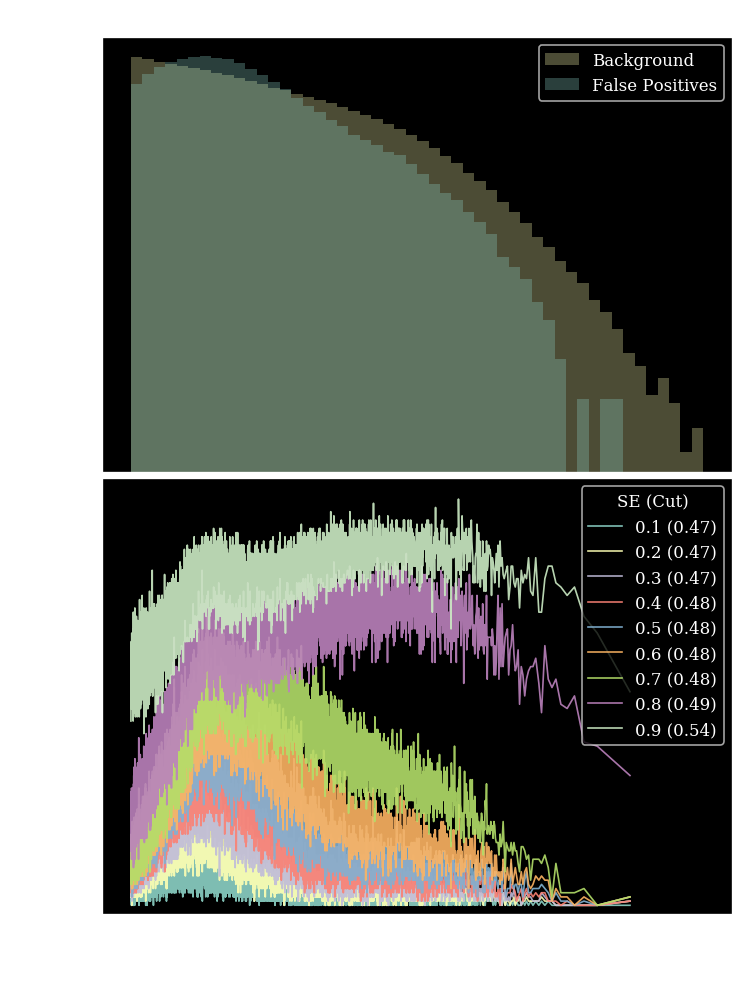

strength 9.999999999999996
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (301.3s)
 Train: loss:0.0218, acc:77% || Val: loss: 0.0618, acc:78%, R50: 15.7955, 1/JSD: 79816.9912
Epoch:0200/0200  (597.4s)
 Train: loss:0.0199, acc:80% || Val: loss: 0.0577, acc:81%, R50: 21.0553, 1/JSD: 64005.4982


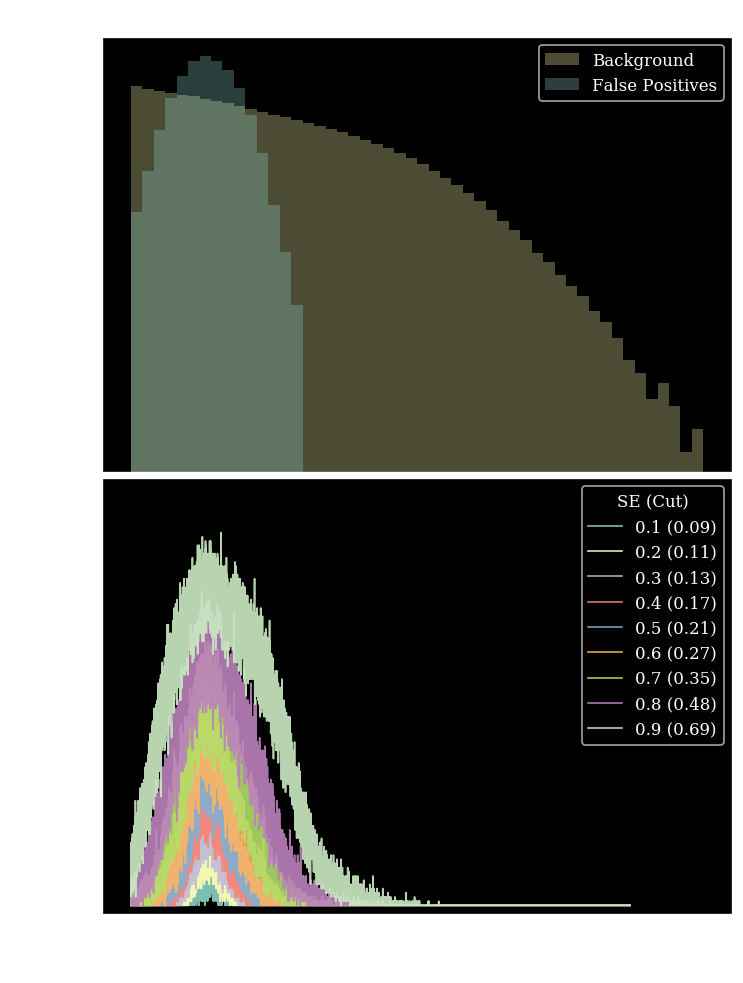

strength 1.0
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (301.6s)
 Train: loss:0.1006, acc:80% || Val: loss: 0.0558, acc:83%, R50: 22.6337, 1/JSD: 39636.6801
Epoch:0200/0200  (596.3s)
 Train: loss:0.0942, acc:81% || Val: loss: 0.0541, acc:83%, R50: 23.5916, 1/JSD: 44497.6180


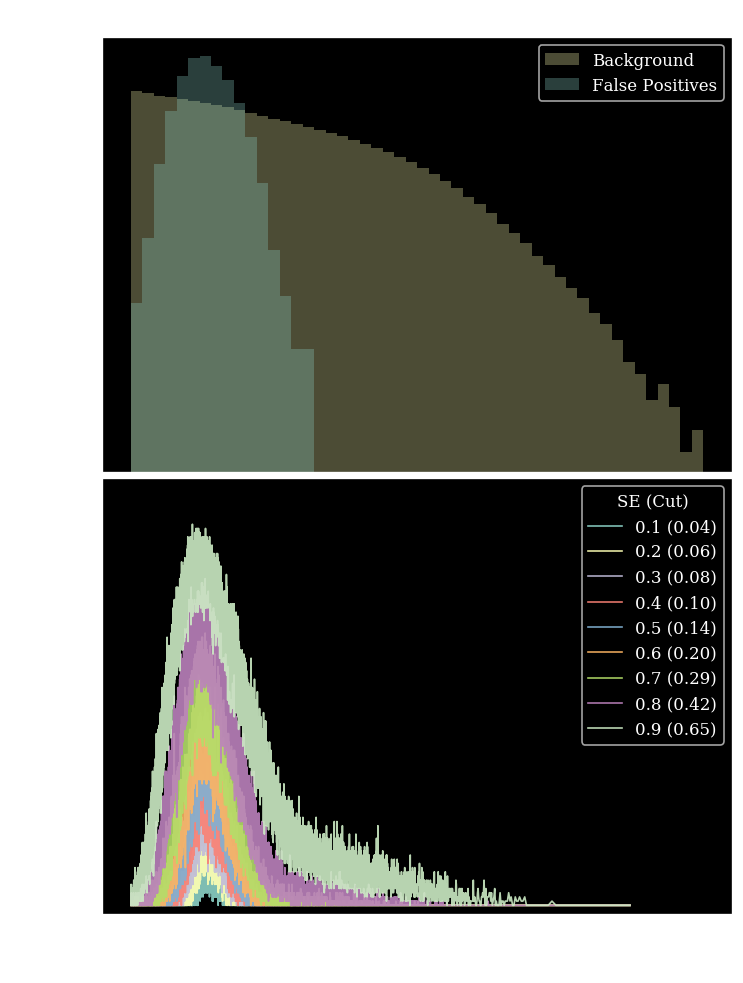

strength 0.01
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (301.5s)
 Train: loss:0.1925, acc:82% || Val: loss: 0.0555, acc:85%, R50: 23.5950, 1/JSD: 52979.0689
Epoch:0200/0200  (596.9s)
 Train: loss:0.1829, acc:81% || Val: loss: 0.0538, acc:84%, R50: 24.8363, 1/JSD: 58713.7570


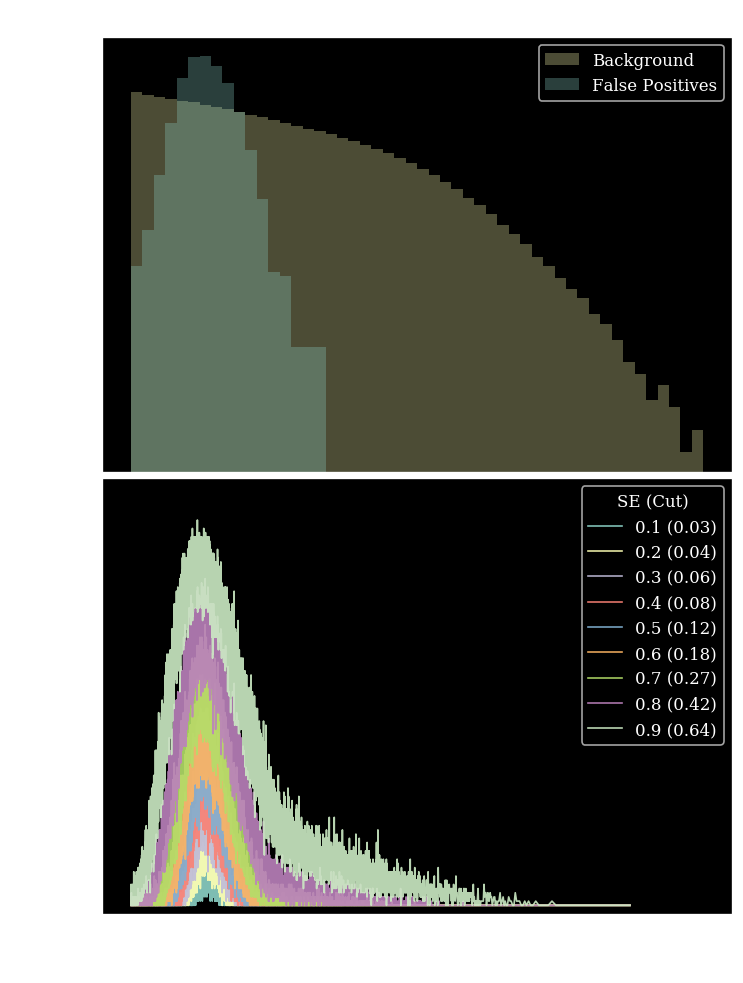

In [7]:
for i,strength in enumerate([100,50,10,1e-2]):
    frac = strength/(1+strength)
    print("strength",frac/(1-frac))
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  Disco(frac=frac,labels=traindataset.labels,order=1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNDisLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    plot_stuff(model=model_L,name="DisCo DNN",X=test[:,1:11],y=test_labels,x_biased=test[:,0])

# Linear

strength 15.0
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (137.7s)
 Train: loss:0.0441, acc:29% || Val: loss: 0.1951, acc:80%, R50: 2.2613, 1/JSD: 376057.8923
Epoch:0200/0200  (267.7s)
 Train: loss:0.0439, acc:30% || Val: loss: 0.1951, acc:80%, R50: 2.2227, 1/JSD: 379844.7845


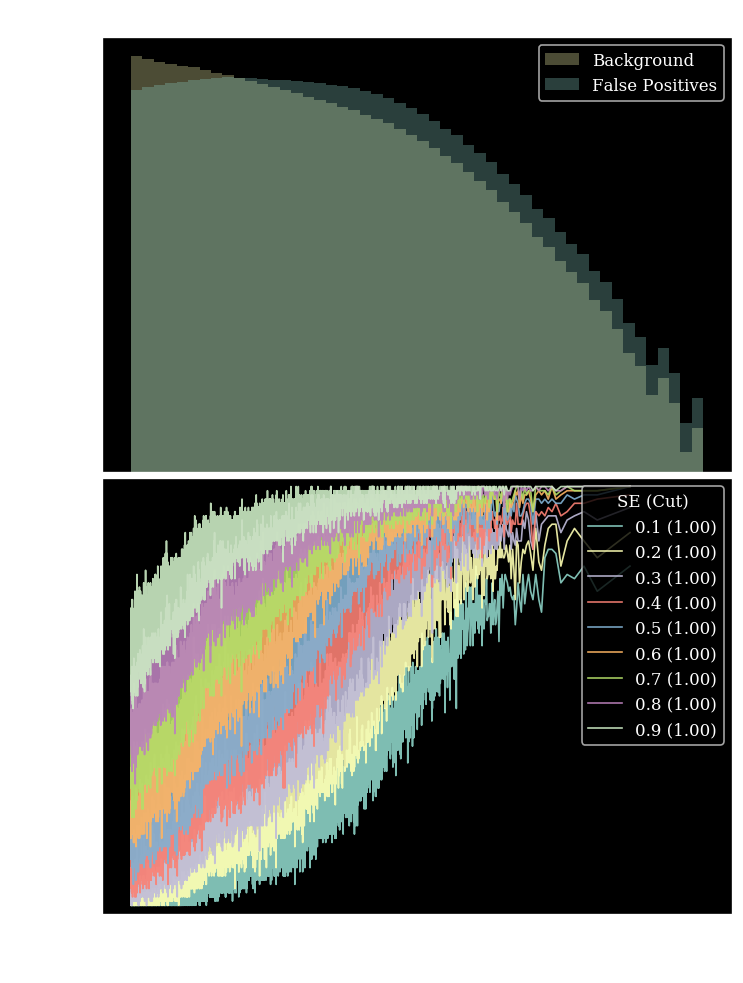

strength 9.999999999999996
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (136.9s)
 Train: loss:0.0642, acc:29% || Val: loss: 0.1951, acc:80%, R50: 2.4953, 1/JSD: 348598.2001
Epoch:0200/0200  (267.5s)
 Train: loss:0.0639, acc:30% || Val: loss: 0.1951, acc:80%, R50: 2.4886, 1/JSD: 356169.2764


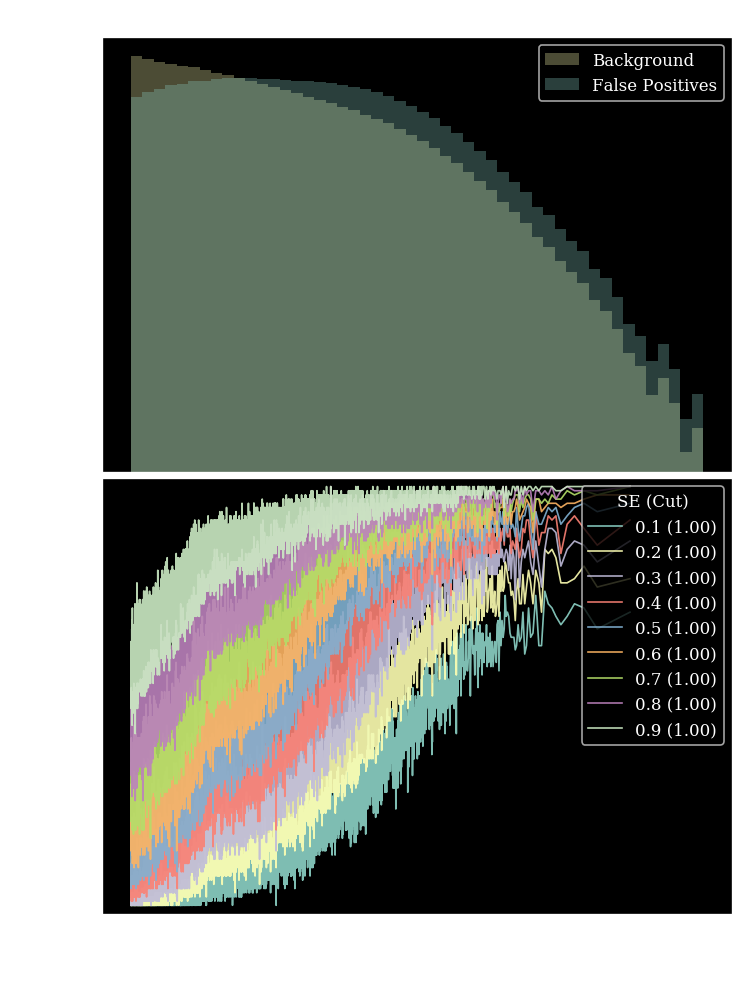

strength 7.9999999999999964
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (138.5s)
 Train: loss:0.0784, acc:29% || Val: loss: 0.1950, acc:80%, R50: 2.8725, 1/JSD: 342819.9995
Epoch:0200/0200  (270.0s)
 Train: loss:0.0780, acc:30% || Val: loss: 0.1949, acc:80%, R50: 3.2830, 1/JSD: 296442.5870


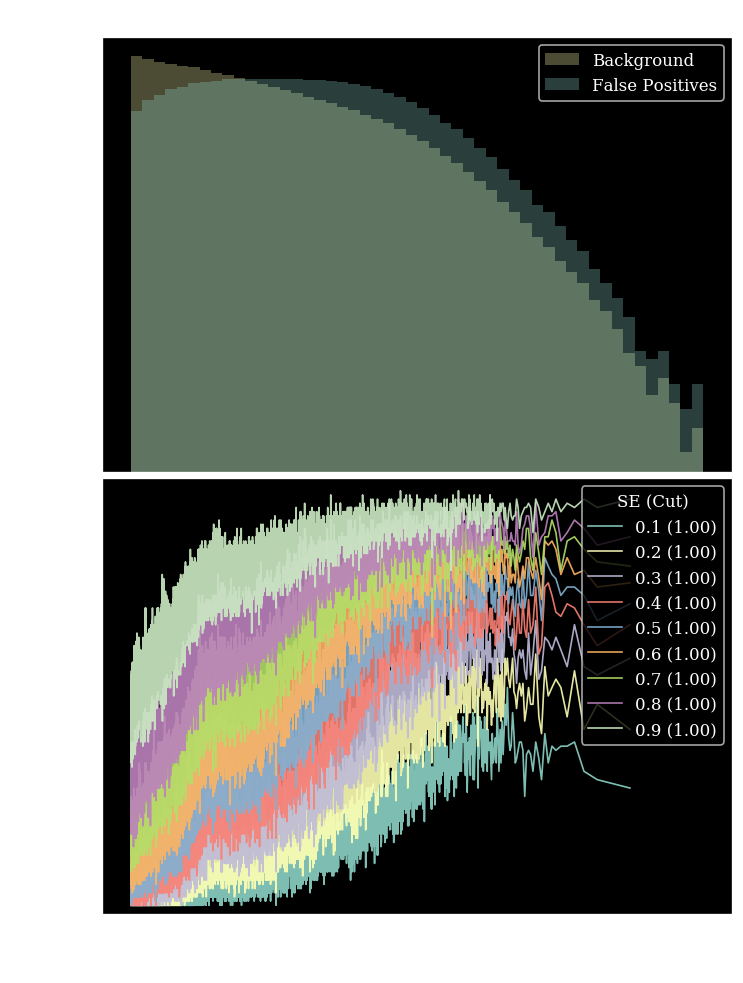

strength 5.000000000000002
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (137.0s)
 Train: loss:0.0615, acc:68% || Val: loss: 0.0897, acc:86%, R50: 19.9468, 1/JSD: 56394.2776
Epoch:0200/0200  (266.3s)
 Train: loss:0.0553, acc:70% || Val: loss: 0.0878, acc:87%, R50: 22.8785, 1/JSD: 60122.6658


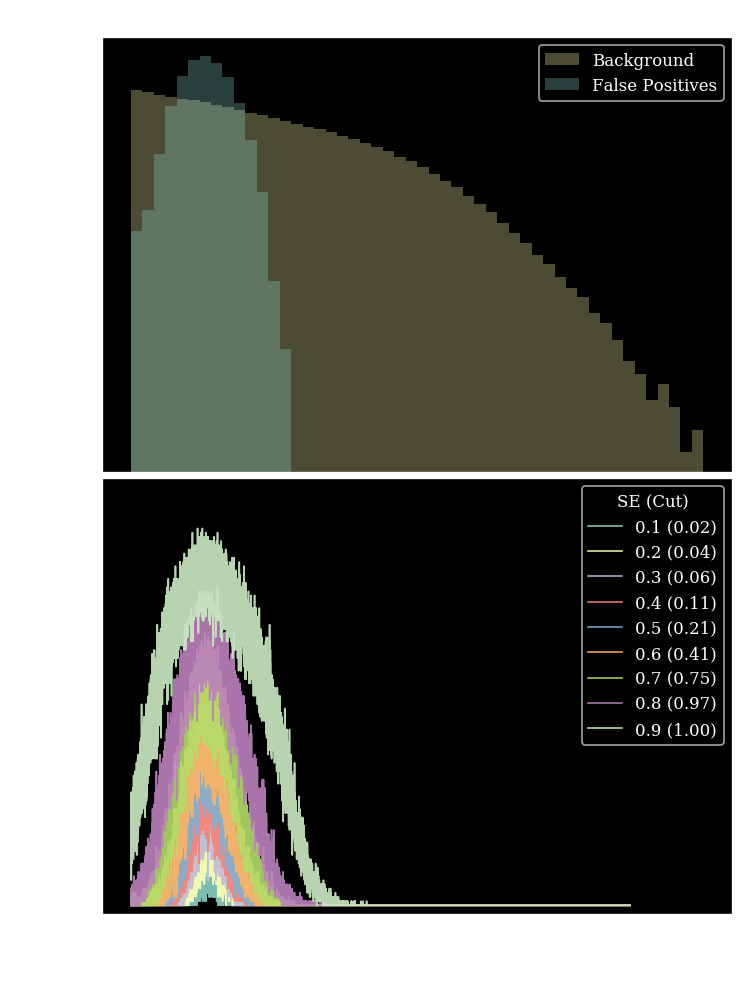

strength 1.0
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (137.1s)
 Train: loss:0.1322, acc:77% || Val: loss: 0.0685, acc:86%, R50: 22.9629, 1/JSD: 42895.2598
Epoch:0200/0200  (267.8s)
 Train: loss:0.1258, acc:77% || Val: loss: 0.0658, acc:86%, R50: 23.2264, 1/JSD: 36313.6375


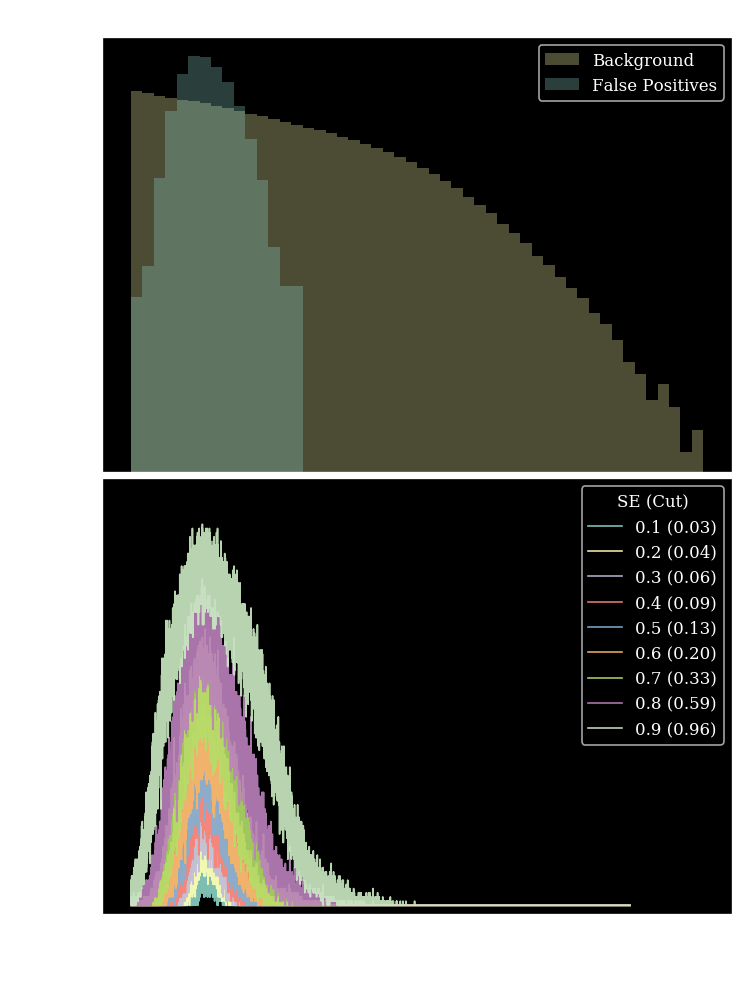

strength 0.1
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (135.3s)
 Train: loss:0.1906, acc:80% || Val: loss: 0.0569, acc:84%, R50: 22.9549, 1/JSD: 51651.6770
Epoch:0200/0200  (266.1s)
 Train: loss:0.1800, acc:81% || Val: loss: 0.0558, acc:85%, R50: 24.1511, 1/JSD: 41005.8293


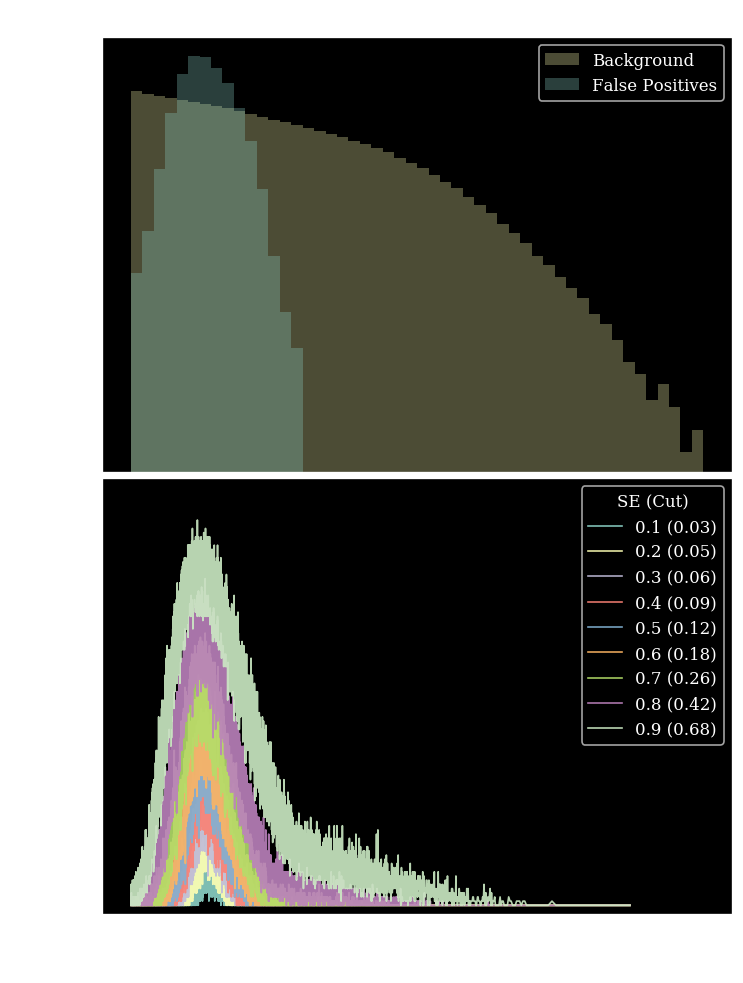

strength 0.01
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0971, acc:30%, R50: 2.8764, 1/JSD: 696521.1021
Epoch:0100/0200  (137.2s)
 Train: loss:0.1942, acc:82% || Val: loss: 0.0555, acc:85%, R50: 23.3810, 1/JSD: 56893.5367
Epoch:0200/0200  (267.2s)
 Train: loss:0.1844, acc:81% || Val: loss: 0.0540, acc:84%, R50: 24.5957, 1/JSD: 53329.7954


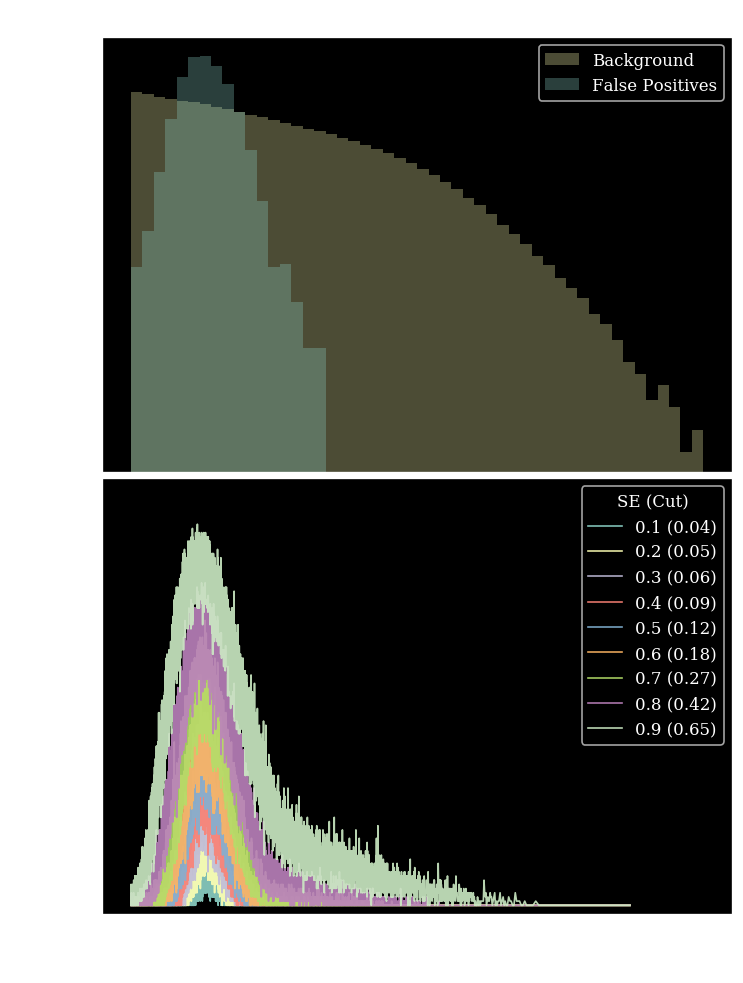

In [8]:
for i,strength in enumerate([100,50,10,5,1,1e-2]):
    frac = strength/(1+strength)
    print("strength",frac/(1-frac))
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNflatLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    plot_stuff(model=model_L,name="Flat DNN",X=test[:,1:11],y=test_labels,x_biased=test[:,0])

In [9]:
asdfasf 

NameError: name 'asdfasf' is not defined